In [1]:
import os
import sys
import math
import gc
import random
import joblib
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(15,10)
sns.set(rc={'figure.figsize':(20,10)})
plt.style.use('seaborn') # seaborn 스타일로 변환
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [4]:
train = pd.read_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', '2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx'), skiprows = 1)
test = pd.read_excel(os.path.join('..', '..', '0.Data', '02_평가데이터', '2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx'), skiprows = 1)

In [5]:
train = train.loc[(train['상품군'] != '무형') & (train['취급액'].notnull())]
test = test.loc[(test['상품군'] != '무형') & (test['취급액'].notnull())]

In [6]:
train.shape, test.shape

((35379, 8), (0, 8))

# 0. 아이템 메타 만들기 (train + test)

In [999]:
meta_train = pd.read_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', 'train수작업_meta.xlsx'))
meta_test = pd.read_excel(os.path.join('..', '..', '0.Data', '02_평가데이터', 'test수작업_meta.xlsx'))

In [1000]:
meta_train = meta_train.loc[meta_train['상품군'] != '무형']
meta_test = meta_test.loc[meta_test['상품군'] != '무형']

In [1001]:
meta = pd.concat([meta_train, meta_test], axis = 0)

In [1011]:
meta2 = meta.drop_duplicates('NEW상품명')[['상품코드', '상품명', '상품군', '판매단가', '마더코드']]

In [429]:
# train + test의 모든 마더코드 803개
mother = meta.loc[meta['NEW상품명'].notnull(), '마더코드'].drop_duplicates().reset_index(drop = True).reset_index()
mother

,index,마더코드
0,0,100292
1,1,100293
2,2,100748
3,3,100024
4,4,100536
...,...,...
798,798,100012
799,799,100014
800,800,100825
801,801,100005


In [551]:
pd.pivot_table(prep_train, index = 'user', columns = '마더코드', values = '취급액', aggfunc = 'sum')

마더코드,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
user,,,,,,,,,,,,,,,,,,,,,
1-0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,502060000.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,129006000.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-12,nan,nan,nan,nan,nan,nan,nan,nan,61060000.000,nan,...,511545000.000,nan,nan,nan,nan,nan,228789000.000,nan,nan,493023000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,124368000.000,nan,nan,nan,nan,nan,63287000.000,nan,nan,nan
9-6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9-7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [430]:
# train + test의 모든 아이템 1622개

In [431]:
item = meta.loc[meta['NEW상품명'].notnull(), ['NEW상품명', '상품군', '마더코드']].drop_duplicates('NEW상품명').reset_index(drop = True).reset_index().rename(columns = {'index' : 'NEW상품코드'})
item

,NEW상품코드,NEW상품명,상품군,마더코드
0,0,가이거 남성 블랙 에디션 다이아몬드 워치,잡화,100292
1,1,가이거 무빙스타 다이아몬드 워치,잡화,100293
2,2,가이거 무빙스타 다이아몬드 워치 + 보석함,잡화,100293
3,3,가이거 여성 블랙 에디션 다이아몬드 워치,잡화,100292
4,4,가이거 제니스시계 주얼리세트,잡화,100293
...,...,...,...,...
1617,1617,QISS 프리미어 아침에 끌리다 마시는한끼 21통,농수축,100825
1618,1618,QISS 프리미어 아침에 끌리다 마시는한끼 42통,농수축,100825
1619,1619,W클라우드 남성 데일리 트레킹화 3종,잡화,100005
1620,1620,W클라우드 여성 데일리 트레킹화 3종,잡화,100005


In [13]:
# train에 존재하는 NEW상품은 총 1355개
train = train.merge(meta.drop_duplicates('상품코드')[['상품코드', 'NEW상품명']], on = '상품코드', how = 'left').merge(item[['NEW상품코드', 'NEW상품명']], on = 'NEW상품명', how = 'left')
train['NEW상품코드'].nunique()

1355

In [14]:
train

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드
0,2019-01-01 06:00:00,20.000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.000,테이트 남성 셀린 니트 3종,859
1,2019-01-01 06:00:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.000,테이트 여성 셀린 니트 3종,860
2,2019-01-01 06:20:00,20.000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.000,테이트 남성 셀린 니트 3종,859
3,2019-01-01 06:20:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.000,테이트 여성 셀린 니트 3종,860
4,2019-01-01 06:40:00,20.000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.000,테이트 남성 셀린 니트 3종,859
...,...,...,...,...,...,...,...,...,...,...
35374,2019-12-31 23:40:00,nan,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.000,쿠첸 압력밥솥 6인용,812
35375,2020-01-01 00:00:00,20.000,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.000,쿠첸 압력밥솥 10인용,813
35376,2020-01-01 00:00:00,nan,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.000,쿠첸 압력밥솥 10인용,813
35377,2020-01-01 00:00:00,nan,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.000,쿠첸 압력밥솥 6인용,812


# 1. 데이터 전처리 (판매량 및 11월 이후 날짜 조정)

In [15]:
# 판매량
import math
train['판매량'] = train['취급액'] / train['판매단가']
train['판매량'] = train['판매량'].fillna(0).apply(lambda x : math.ceil(x))

In [16]:
# 11월 1일 이후 시간 조정해 줘야함

In [17]:
train['방송날'] = train['방송일시'].dt.date
train['방송월'] = train['방송일시'].dt.month
train['방송일'] = train['방송일시'].dt.day
train['방송시간'] = train['방송일시'].dt.hour

In [18]:
# 11월 1일부터 바뀐 편성표 시간 맞춰주기
train_a = train.loc[train['방송일시'] < '2019-11-01 02:00:00']
train_b = train.loc[train['방송일시'] > '2019-11-01 02:00:00']

In [19]:
# 11월 1일부터는 20분씩 땡겨줘야함
train_b['new_방송일시'] = train_b['방송일시'] - datetime.timedelta(minutes = 20)

In [20]:
train_b['방송날'] = train_b['new_방송일시'].dt.date
train_b['방송월'] = train_b['new_방송일시'].dt.month
train_b['방송일'] = train_b['new_방송일시'].dt.day
train_b['방송시간'] = train_b['new_방송일시'].dt.hour

In [21]:
prep_train = pd.concat([train_a, train_b.drop('new_방송일시', axis = 1)], axis = 0)

In [22]:
prep_train['연도'] = prep_train['방송일시'].dt.year

In [23]:
prep_train = prep_train.loc[prep_train['상품군'] != '무형']

In [24]:
prep_train['연도'] = 2019

In [27]:
prep_train

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,NEW상품명,NEW상품코드,판매량,방송날,방송월,방송일,방송시간,연도
0,2019-01-01 06:00:00,20.000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.000,테이트 남성 셀린 니트 3종,859,53,2019-01-01,1,1,6,2019
1,2019-01-01 06:00:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.000,테이트 여성 셀린 니트 3종,860,110,2019-01-01,1,1,6,2019
2,2019-01-01 06:20:00,20.000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.000,테이트 남성 셀린 니트 3종,859,82,2019-01-01,1,1,6,2019
3,2019-01-01 06:20:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.000,테이트 여성 셀린 니트 3종,860,175,2019-01-01,1,1,6,2019
4,2019-01-01 06:40:00,20.000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.000,테이트 남성 셀린 니트 3종,859,168,2019-01-01,1,1,6,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35374,2019-12-31 23:40:00,nan,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.000,쿠첸 압력밥솥 6인용,812,69,2019-12-31,12,31,23,2019
35375,2020-01-01 00:00:00,20.000,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.000,쿠첸 압력밥솥 10인용,813,287,2019-12-31,12,31,23,2019
35376,2020-01-01 00:00:00,nan,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.000,쿠첸 압력밥솥 10인용,813,622,2019-12-31,12,31,23,2019
35377,2020-01-01 00:00:00,nan,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.000,쿠첸 압력밥솥 6인용,812,88,2019-12-31,12,31,23,2019


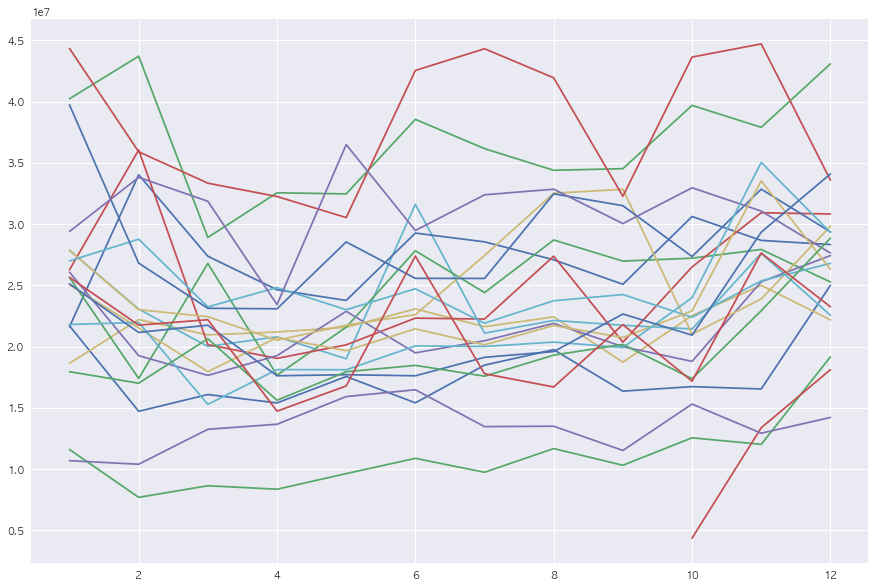

In [145]:
sale = pd.pivot_table(train, index = '방송월', columns = '방송시간', values = '취급액', aggfunc = 'mean')
plt.figure(figsize = (15, 10))
plt.plot(sale)
plt.show()

In [146]:
amount = pd.pivot_table(train, index = '방송월', columns = '방송시간', values = '판매량', aggfunc = 'mean')

In [150]:
(sale.loc[9] * amount.loc[9]).sort_values(ascending = False)

방송시간
16   22347625475.575
17   19415769186.861
13   16986339767.844
18   15384688943.353
15   14172924169.789
10   10607742999.931
9    10230523968.334
8     8786578074.538
14    8697583231.984
7     6352324074.519
11    6274389429.226
19    4972136636.250
12    4849181892.336
23    3537280541.473
20    3244687549.296
21    3161647211.573
22    2626273935.606
0     2588398316.886
6     2135435808.462
1     1716752508.298
2                nan
Name: 9, dtype: float64

In [151]:
dic = {}
for m in range(1, 13):
    value = (sale.loc[m] * amount.loc[m]).sort_values(ascending = False).index
    dic[m] = list(value)

In [153]:
# 1월달 우선 예측 시간대 순서
dic[1]

[17, 16, 15, 18, 13, 8, 14, 12, 10, 11, 19, 0, 7, 9, 23, 20, 21, 6, 1, 22, 2]

In [370]:
raw2 =pd.pivot_table(prep_train, columns = 'user', index = '마더코드', values = '방송일시', aggfunc = 'count')

In [1115]:
raw

마더코드,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
user,,,,,,,,,,,,,,,,,,,,,
1-0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,126.250,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,132.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-12,nan,nan,nan,nan,nan,nan,nan,nan,519.000,nan,...,174.667,nan,nan,nan,nan,nan,1466.000,nan,nan,832.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,258.000,nan,nan,nan,nan,nan,803.000,nan,nan,nan
9-6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9-7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [53]:
np.log(raw)

마더코드,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
user,,,,,,,,,,,,,,,,,,,,,
1-0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,4.838,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,4.883,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-12,nan,nan,nan,nan,nan,nan,nan,nan,6.252,nan,...,5.163,nan,nan,nan,nan,nan,7.290,nan,nan,6.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,5.553,nan,nan,nan,nan,nan,6.688,nan,nan,nan
9-6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9-7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [1092]:
data = joblib.load(os.path.join('..', '..', '0.Data', '05_분석데이터', 'train_FE.pkl'))

In [733]:
locals().update(data)

In [1094]:
time4 = joblib.load(os.path.join('..', '..', '0.Data', '04_임시데이터', 'time4wnd.pkl'))

In [1095]:
locals().update(time4)

In [765]:
X['user'] = prep_train['user'].values

In [850]:
user = X[['user',
 '강수량(mm)_경기',
 '강수량(mm)_광주',
 '강수량(mm)_대구',
 '강수량(mm)_대전',
 '강수량(mm)_부산',
 '강수량(mm)_서울',
 '강수량(mm)_울산',
 '강수량(mm)_인천',
 '기온(°C)_경기',
 '기온(°C)_광주',
 '기온(°C)_대구',
 '기온(°C)_대전',
 '기온(°C)_부산',
 '기온(°C)_서울',
 '기온(°C)_울산',
 '기온(°C)_인천',
 '습도(%)_경기',
 '습도(%)_광주',
 '습도(%)_대구',
 '습도(%)_대전',
 '습도(%)_부산',
 '습도(%)_서울',
 '습도(%)_울산',
 '습도(%)_인천',
 '시정(10m)_경기',
 '시정(10m)_광주',
 '시정(10m)_대구',
 '시정(10m)_대전',
 '시정(10m)_부산',
 '시정(10m)_서울',
 '시정(10m)_울산',
 '시정(10m)_인천',
 '지면온도(°C)_경기',
 '지면온도(°C)_광주',
 '지면온도(°C)_대구',
 '지면온도(°C)_대전',
 '지면온도(°C)_부산',
 '지면온도(°C)_서울',
 '지면온도(°C)_울산',
 '지면온도(°C)_인천',
 '체감온도_경기',
 '체감온도_광주',
 '체감온도_대구',
 '체감온도_대전',
 '체감온도_부산',
 '체감온도_서울',
 '체감온도_울산',
 '체감온도_인천',
 '풍속(m/s)_경기',
 '풍속(m/s)_광주',
 '풍속(m/s)_대구',
 '풍속(m/s)_대전',
 '풍속(m/s)_부산',
 '풍속(m/s)_서울',
 '풍속(m/s)_울산',
 '풍속(m/s)_인천',
 '최고PM10_경기',
 '최고PM10_광주',
 '최고PM10_대구',
 '최고PM10_대전',
 '최고PM10_부산',
 '최고PM10_서울',
 '최고PM10_울산',
 '최고PM10_인천',
 '최고PM25_경기',
 '최고PM25_광주',
 '최고PM25_대구',
 '최고PM25_대전',
 '최고PM25_부산',
 '최고PM25_서울',
 '최고PM25_울산',
 '최고PM25_인천',
 '최저PM10_경기',
 '최저PM10_광주',
 '최저PM10_대구',
 '최저PM10_대전',
 '최저PM10_부산',
 '최저PM10_서울',
 '최저PM10_울산',
 '최저PM10_인천',
 '최저PM25_경기',
 '최저PM25_광주',
 '최저PM25_대구',
 '최저PM25_대전',
 '최저PM25_부산',
 '최저PM25_서울',
 '최저PM25_울산',
 '최저PM25_인천',
 '평균PM10_경기',
 '평균PM10_광주',
 '평균PM10_대구',
 '평균PM10_대전',
 '평균PM10_부산',
 '평균PM10_서울',
 '평균PM10_울산',
 '평균PM10_인천',
 '평균PM25_경기',
 '평균PM25_광주',
 '평균PM25_대구',
 '평균PM25_대전',
 '평균PM25_부산',
 '평균PM25_서울',
 '평균PM25_울산',
 '평균PM25_인천']]

In [767]:
scale_timeY.head()

,방송일시,type2_0,type2_1,type2_2,type2_3,type2_4,type2_5,type2_6,type2_7,type2_8,...,type2_37,type2_38,type2_39,type2_40,type2_41,type2_42,type2_43,방송월,방송일,방송시간(시간)
0,2019-01-01 06:00:00,2.134,-1.606,-0.988,-0.758,0.822,-0.374,0.037,0.012,-0.665,...,-0.132,0.243,-0.290,-0.017,-0.133,0.013,0.218,1,1,6
1,2019-01-01 07:00:00,2.065,-1.552,-0.898,-0.674,0.878,-0.444,0.128,0.131,-0.493,...,-0.049,0.130,-0.201,0.040,-0.260,0.175,0.180,1,1,7
2,2019-01-01 08:00:00,2.005,-1.506,-0.846,-0.622,0.894,-0.475,0.216,0.123,-0.412,...,-0.062,0.168,-0.159,0.053,-0.291,0.182,0.150,1,1,8
3,2019-01-01 09:00:00,2.002,-1.503,-0.841,-0.619,0.895,-0.473,0.222,0.121,-0.405,...,-0.066,0.180,-0.147,0.062,-0.298,0.181,0.142,1,1,9
4,2019-01-01 10:00:00,1.915,-1.434,-0.765,-0.541,0.917,-0.518,0.353,0.107,-0.280,...,-0.082,0.223,-0.107,0.063,-0.332,0.200,0.102,1,1,10


In [851]:
user['방송월'] = user['user'].apply(lambda x : int(x.split('-')[0]))
user['방송시간(시간)'] = user['user'].apply(lambda x : int(x.split('-')[1]))

In [852]:
user = user[['user', '방송월', '방송시간(시간)'] + list(user.columns[1:-2])]

In [857]:
user['방송일'] = X['방송일'].values

In [859]:
user = user.merge(scale_timeY.iloc[:, 1:], on = ['방송월', '방송시간(시간)', '방송일'], how = 'left')

In [860]:
user

,user,방송월,방송시간(시간),강수량(mm)_경기,강수량(mm)_광주,강수량(mm)_대구,강수량(mm)_대전,강수량(mm)_부산,강수량(mm)_서울,강수량(mm)_울산,...,type2_34,type2_35,type2_36,type2_37,type2_38,type2_39,type2_40,type2_41,type2_42,type2_43
0,1-6,1,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.185,0.379,-0.060,-0.132,0.243,-0.290,-0.017,-0.133,0.013,0.218
1,1-6,1,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.185,0.379,-0.060,-0.132,0.243,-0.290,-0.017,-0.133,0.013,0.218
2,1-6,1,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.185,0.379,-0.060,-0.132,0.243,-0.290,-0.017,-0.133,0.013,0.218
3,1-6,1,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.185,0.379,-0.060,-0.132,0.243,-0.290,-0.017,-0.133,0.013,0.218
4,1-6,1,6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.185,0.379,-0.060,-0.132,0.243,-0.290,-0.017,-0.133,0.013,0.218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35374,12-23,12,23,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.135,0.040,-0.012,-0.097,-0.022,-0.078,-0.103,0.012,0.012,0.105
35375,12-23,12,23,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.135,0.040,-0.012,-0.097,-0.022,-0.078,-0.103,0.012,0.012,0.105
35376,12-23,12,23,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.135,0.040,-0.012,-0.097,-0.022,-0.078,-0.103,0.012,0.012,0.105
35377,12-23,12,23,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.135,0.040,-0.012,-0.097,-0.022,-0.078,-0.103,0.012,0.012,0.105


In [861]:
u = user.groupby('user').mean().reset_index()

In [862]:
u = u.merge(scale_timeR, on = '방송시간(시간)', how = 'left').fillna(0)

In [863]:
from sklearn.metrics.pairwise import cosine_similarity

In [872]:
u = u.drop(['방송월', '방송시간(시간)', '방송일'], axis = 1)

In [873]:
sim_user = pd.DataFrame(cosine_similarity(u.iloc[:, 1:]), columns = u['user'])

In [874]:
sim_user.index = u.user

In [875]:
sim_user

user,1-0,1-1,1-10,1-11,1-12,1-13,1-14,1-15,1-16,1-17,...,9-18,9-19,9-20,9-21,9-22,9-23,9-6,9-7,9-8,9-9
user,,,,,,,,,,,,,,,,,,,,,
1-0,1.000,1.000,0.998,0.997,0.997,0.994,0.996,0.996,0.997,0.998,...,0.938,0.927,0.945,0.957,0.970,0.963,0.974,0.973,0.980,0.970
1-1,1.000,1.000,0.998,0.997,0.997,0.993,0.995,0.996,0.996,0.998,...,0.936,0.925,0.943,0.955,0.969,0.962,0.974,0.973,0.980,0.970
1-10,0.998,0.998,1.000,1.000,0.999,0.996,0.997,0.997,0.997,0.998,...,0.933,0.923,0.941,0.953,0.968,0.962,0.975,0.974,0.980,0.970
1-11,0.997,0.997,1.000,1.000,0.999,0.996,0.997,0.997,0.997,0.997,...,0.930,0.920,0.938,0.951,0.966,0.960,0.974,0.973,0.979,0.969
1-12,0.997,0.997,0.999,0.999,1.000,0.999,0.999,0.999,0.999,0.999,...,0.940,0.931,0.949,0.961,0.973,0.968,0.980,0.979,0.984,0.976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,0.963,0.962,0.962,0.960,0.968,0.975,0.971,0.971,0.969,0.966,...,0.992,0.991,0.996,0.998,0.999,1.000,0.994,0.993,0.994,0.997
9-6,0.974,0.974,0.975,0.974,0.980,0.985,0.983,0.982,0.980,0.978,...,0.977,0.975,0.983,0.989,0.994,0.994,1.000,0.999,0.998,0.998
9-7,0.973,0.973,0.974,0.973,0.979,0.984,0.982,0.981,0.979,0.978,...,0.976,0.973,0.981,0.987,0.993,0.993,0.999,1.000,0.998,0.998


In [181]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

In [876]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [877]:
u_scale = pd.concat([u[['user']], pd.DataFrame(scaler.fit_transform(u.iloc[:, 1:]), columns = u.columns[1:])], axis = 1)

In [878]:
# 각 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산하여 리스트로 저장
wss = []
sis = []

for k in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(u_scale.iloc[:,1:])
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(u_scale.iloc[:,1:], kmeans.labels_))

100%|██████████| 8/8 [00:00<00:00, 21.54it/s]


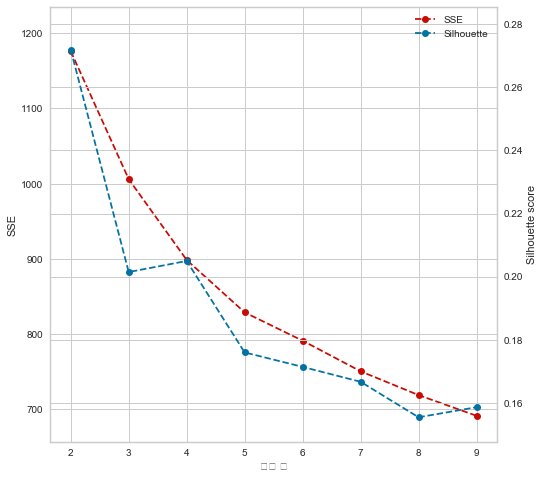

In [879]:
# 군집 수에 따른 SSE와 Silhouette score 시각화

fig, ax1 = plt.subplots(figsize = (8,8))
ax2 = ax1.twinx() # 양쪽 축을 개별로 사용

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

In [880]:
import warnings
warnings.filterwarnings(action='ignore') # 경고창 없애기

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

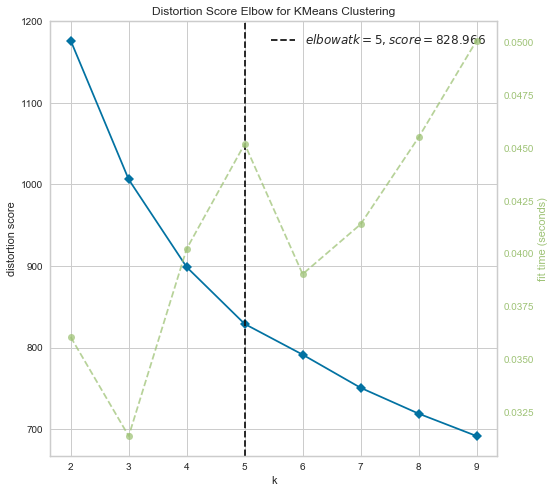

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb87b0d3c90>,
                 k=None, model=None)

In [881]:
plt.figure(figsize = (8,8))
kelbow_visualizer(KMeans(random_state=0), u_scale.iloc[:,1:], k=(2,10))

In [882]:
kmeans = KMeans(n_clusters = 5).fit(u.iloc[:,1:].values)

In [883]:
u['segment'] = kmeans.labels_

In [891]:
u['segment'].value_counts()

0    64
4    62
1    43
2    40
3    33
Name: segment, dtype: int64

In [1108]:
pd.pivot_table(prep_train, columns = 'user', index = '마더코드', values = '방송일시', aggfunc = 'count').T.reset_index()

마더코드,user,100000,100001,100002,100006,100009,100010,100013,100015,100016,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
0,1-0,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,1-10,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,47.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1-11,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,12.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1-12,nan,nan,nan,nan,nan,nan,nan,nan,6.000,...,36.000,nan,nan,nan,nan,nan,6.000,nan,nan,12.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9-23,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,4.000,nan,nan,nan,nan,nan,3.000,nan,nan,nan
238,9-6,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
239,9-7,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
240,9-8,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,12.000,nan,nan,nan,nan,nan,nan,nan,nan,nan


# 1. 각 군집에서 다른 군집과 비교해 상대적으로 가장 자주/많이 판매되는 마더코드 선별

In [887]:
prep_train['user'] = user['user'].values

In [894]:
prep_train = prep_train.merge(u[['user', 'segment']], on = 'user', how = 'left')

In [909]:
temp = prep_train.groupby(['segment', '마더코드']).count()['방송일시'].reset_index().sort_values(['segment', '방송일시'], ascending = [True, False])

In [910]:
temp['segment'].value_counts()

4    411
0    353
2    302
3    292
1    263
Name: segment, dtype: int64

In [911]:
temp

,segment,마더코드,방송일시
65,0,100148,796
188,0,100448,492
347,0,100837,407
98,0,100205,322
66,0,100149,305
...,...,...,...
1543,4,100670,2
1549,4,100695,2
1558,4,100711,2
1602,4,100805,2


In [912]:
temp['score'] = None
for m in tqdm(temp['마더코드']):
    temp.loc[temp['마더코드'] == m, 'score'] = temp.loc[temp['마더코드'] == m].apply(lambda x : (x - np.mean(x)) / np.std(x))['방송일시'].values

100%|██████████| 1621/1621 [00:09<00:00, 166.75it/s]


In [913]:
temp['score'] = temp['score'].fillna(0)

In [914]:
rec1 = dict()
for s in temp['segment'].unique():
    rec1[s] = list(temp.loc[temp['segment'] == s].sort_values('score', ascending = False)['마더코드'][:5])

In [915]:
# 각 군집에서 가장 자주 판매된~
rec1

{0: [100149, 100205, 100148, 100374, 100448],
 1: [100026, 100255, 100844, 100202, 100499],
 2: [100266, 100241, 100782, 100102, 100315],
 3: [100763, 100475, 100353, 100099, 100224],
 4: [100610, 100766, 100841, 100612, 100702]}

In [916]:
temp = prep_train.groupby(['segment', '마더코드']).mean()['판매량'].reset_index().sort_values(['segment', '판매량'], ascending = [True, False])

In [917]:
temp['score'] = None
for m in tqdm(temp['마더코드']):
    temp.loc[temp['마더코드'] == m, 'score'] = temp.loc[temp['마더코드'] == m].apply(lambda x : (x - np.mean(x)) / np.std(x))['판매량'].values

100%|██████████| 1621/1621 [00:08<00:00, 190.87it/s]


In [918]:
temp['score'] = temp['score'].fillna(0)

In [919]:
rec2 = dict()
for s in temp['segment'].unique():
    rec2[s] = list(temp.loc[temp['segment'] == s].sort_values('score', ascending = False)['마더코드'][:5])

In [920]:
rec2

{0: [100766, 100266, 100584, 100327, 100483],
 1: [100192, 100226, 100305, 100182, 100348],
 2: [100635, 100025, 100346, 100511, 100575],
 3: [100390, 100809, 100458, 100664, 100782],
 4: [100148, 100323, 100244, 100271, 100788]}

# 2.각 user와 가장 가까운 user의 최고 많이/자주 판매된 item

In [713]:
def get_similar_user_item(raw, raw2, sim, user):
    ex_item = raw.columns[raw.loc[user] > 0]
    most_similr = sim.loc[user].sort_values(ascending = False).index[1]
    
    v1 = raw.loc[most_similr].sort_values(ascending = False).index[0]
    v2 = raw2.loc[most_similr].sort_values(ascending = False).index[0]
    rec= list(set([v1, v2]))
    
    return rec

In [1101]:
u

,user,강수량(mm)_경기,강수량(mm)_광주,강수량(mm)_대구,강수량(mm)_대전,강수량(mm)_부산,강수량(mm)_서울,강수량(mm)_울산,강수량(mm)_인천,기온(°C)_경기,...,type3_2,type3_3,type3_4,type3_5,type3_6,type3_7,type3_8,type3_9,type3_10,segment
0,1-0,0.000,0.067,0.000,0.000,0.024,0.000,0.005,0.029,-2.697,...,-0.820,0.653,0.781,1.322,-0.827,0.505,-0.605,-0.044,-0.635,4
1,1-1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-3.378,...,0.497,1.349,1.026,0.489,-0.828,-0.309,0.377,-0.084,0.945,4
2,1-10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.858,...,-1.320,-0.097,-1.206,1.047,0.263,-0.180,-0.373,0.183,0.504,2
3,1-11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.969,...,-0.511,1.013,-1.075,1.065,0.741,0.502,-0.317,-0.262,0.096,4
4,1-12,0.000,0.075,0.159,0.000,0.085,0.000,0.157,0.000,2.542,...,0.329,1.549,0.414,-0.320,0.359,-0.490,0.117,-0.973,-0.064,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9-23,0.940,0.098,0.275,0.333,0.207,0.128,0.952,0.256,20.155,...,-1.689,0.497,0.063,-0.163,0.121,1.053,1.054,0.007,-0.415,1
238,9-6,0.136,0.674,0.338,0.313,0.300,0.243,0.191,0.123,19.806,...,-0.145,0.043,-0.356,-0.890,0.640,0.005,-0.306,-0.043,0.071,3
239,9-7,0.080,0.853,0.401,0.260,0.209,0.164,0.265,0.239,20.159,...,-1.076,-1.467,-0.378,-1.200,-0.122,0.878,-0.099,-0.163,0.521,3
240,9-8,0.026,0.274,0.250,0.166,0.131,0.019,0.199,0.266,20.886,...,-1.618,-1.544,0.392,0.417,0.168,-0.671,0.892,-0.047,-0.145,3


In [715]:
get_similar_user_item(raw, raw2, sim, '1-1')

[100435, 100491]

In [1099]:
sim

user,1-0,1-1,1-10,1-11,1-12,1-13,1-14,1-15,1-16,1-17,...,9-18,9-19,9-20,9-21,9-22,9-23,9-6,9-7,9-8,9-9
user,,,,,,,,,,,,,,,,,,,,,
1-0,1.000,1.000,0.998,0.997,0.997,0.994,0.996,0.996,0.997,0.998,...,0.938,0.927,0.945,0.957,0.970,0.963,0.974,0.973,0.980,0.970
1-1,1.000,1.000,0.998,0.997,0.997,0.993,0.995,0.996,0.996,0.997,...,0.936,0.925,0.943,0.955,0.969,0.962,0.974,0.973,0.980,0.970
1-10,0.998,0.998,1.000,1.000,0.999,0.996,0.997,0.997,0.997,0.998,...,0.933,0.923,0.941,0.953,0.968,0.962,0.975,0.974,0.980,0.970
1-11,0.997,0.997,1.000,1.000,0.999,0.996,0.997,0.997,0.997,0.997,...,0.930,0.920,0.938,0.951,0.966,0.960,0.974,0.973,0.979,0.969
1-12,0.997,0.997,0.999,0.999,1.000,0.999,0.999,0.999,0.999,0.999,...,0.940,0.931,0.949,0.961,0.973,0.968,0.980,0.979,0.984,0.976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,0.963,0.962,0.962,0.960,0.968,0.975,0.971,0.971,0.969,0.966,...,0.992,0.991,0.996,0.998,0.999,1.000,0.994,0.993,0.994,0.997
9-6,0.974,0.974,0.975,0.974,0.980,0.985,0.983,0.982,0.980,0.978,...,0.977,0.975,0.983,0.989,0.994,0.994,1.000,0.999,0.998,0.998
9-7,0.973,0.973,0.974,0.973,0.979,0.984,0.982,0.981,0.979,0.978,...,0.976,0.973,0.981,0.987,0.993,0.993,0.999,1.000,0.998,0.998


In [820]:
user_content = {}
for user in ae.index:
    r = get_similar_user_item(raw, raw2, sim, user)
    user_content[user] = r

# 3.user가 가장 많이 판매한 item과 가장 가까운 item

In [395]:
emb = pd.read_excel(os.path.join('..', '..', '0.Data', '04_임시데이터', 'new_version4.xlsx'), index_col = 0)

In [432]:
item = item.merge(emb, on = 'NEW상품명', how = 'left')

In [433]:
tn_meta = pd.read_csv(os.path.join('..', '..', '0.Data', '04_임시데이터', 'item_meta(train).csv'), encoding = 'cp949')
te_meta = pd.read_csv(os.path.join('..', '..', '0.Data', '04_임시데이터', 'item_meta(test).csv'), encoding = 'cp949')

In [434]:
meta_T = pd.concat([tn_meta, te_meta], axis = 0).drop_duplicates('NEW상품명')

In [435]:
item = item.merge(meta_T, on = ['NEW상품코드', 'NEW상품명', '상품군'], how = 'left')

In [499]:
item = item.drop_duplicates('NEW상품명')

In [500]:
prep_item = item.drop(['NEW상품코드', 'NEW상품명', '상품군', '마더코드', '전체_가격대'], axis = 1)

In [501]:
prep_item = pd.concat([prep_item, pd.get_dummies(item[['상품군', '전체_가격대']])], axis = 1)

In [502]:
scaler = MinMaxScaler()
prep_item[['NEW_최고판매단가','NEW_최저판매단가', 'NEW_평균판매단가', 'NEW_중간판매단가', 'NEW_최고-최저', 'NEW_분산', 'NEW_표준편차']] = pd.DataFrame(scaler.fit_transform(prep_item[['NEW_최고판매단가','NEW_최저판매단가', 'NEW_평균판매단가', 'NEW_중간판매단가', 'NEW_최고-최저', 'NEW_분산', 'NEW_표준편차']]))

In [514]:
prep_item = prep_item.drop('전체_가격대', axis = 1)

In [517]:
prep_item = pd.concat([prep_item, pd.get_dummies(item[['전체_가격대']])], axis = 1)

In [648]:
prep_item

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,속옷,의류,이미용,잡화,주방,침구,전체_가격대_고가,전체_가격대_저가,전체_가격대_중저가,전체_가격대_초고가
0,-0.012,-0.041,0.020,0.011,-0.029,-0.047,-0.001,-0.042,-0.030,0.010,...,0,0,0,1,0,0,1,0,0,0
1,-0.012,-0.041,0.020,0.011,-0.029,-0.047,-0.001,-0.042,-0.030,0.010,...,0,0,0,1,0,0,1,0,0,0
2,-0.012,-0.041,0.020,0.011,-0.029,-0.047,-0.001,-0.042,-0.030,0.010,...,0,0,0,1,0,0,1,0,0,0
3,-0.012,-0.041,0.020,0.011,-0.029,-0.047,-0.001,-0.042,-0.030,0.010,...,0,0,0,1,0,0,1,0,0,0
4,-0.012,-0.041,0.020,0.011,-0.029,-0.047,-0.001,-0.042,-0.030,0.010,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,0.006,0.035,0.025,-0.032,0.045,0.021,0.034,0.045,-0.047,0.022,...,0,0,0,0,0,0,0,1,0,0
1620,0.006,0.035,0.025,-0.032,0.045,0.021,0.034,0.045,-0.047,0.022,...,0,0,0,0,0,0,0,0,1,0
1621,0.013,0.025,0.001,-0.023,-0.039,0.038,0.043,0.005,-0.026,0.031,...,0,0,0,1,0,0,0,1,0,0
1622,0.013,0.025,0.001,-0.023,-0.039,0.038,0.043,0.005,-0.026,0.031,...,0,0,0,1,0,0,0,1,0,0


In [530]:
sim_item = pd.DataFrame(cosine_similarity(prep_item.fillna(0)), columns = item['NEW상품명'])

In [531]:
sim_item.index = item['NEW상품명']

In [607]:
sim_item

NEW상품명,가이거 남성 블랙 에디션 다이아몬드 워치,가이거 무빙스타 다이아몬드 워치,가이거 무빙스타 다이아몬드 워치 + 보석함,가이거 여성 블랙 에디션 다이아몬드 워치,가이거 제니스시계 주얼리세트,가이거 콘체르토 다이아몬드 워치(주얼라) 3종,갈란테 프리미엄 에디션(남성화 + 면도기) 3종 + 1종,거미손 차량용 공기청정기,경남제약 레모나 S산 350포,골드파일 카로 여행가방 세트 9종,...,AAC 삼채 포기김치 10kg,AAC 녹두삼계탕 8팩,AAC 녹두삼계탕죽 세트,AAC 별미김치 3종,AAC 여름 별미김치 3종,QISS 프리미어 아침에 끌리다 마시는한끼 21통,QISS 프리미어 아침에 끌리다 마시는한끼 42통,W클라우드 남성 데일리 트레킹화 3종,W클라우드 여성 데일리 트레킹화 3종,아놀드파마 티셔츠 레깅스 세트
NEW상품명,,,,,,,,,,,,,,,,,,,,,
가이거 남성 블랙 에디션 다이아몬드 워치,1.000,0.989,0.988,0.997,0.991,0.985,0.985,0.330,-0.003,0.984,...,0.329,0.326,0.465,-0.002,-0.004,0.465,0.468,0.403,0.399,0.329
가이거 무빙스타 다이아몬드 워치,0.989,1.000,0.997,0.989,0.992,0.990,0.988,0.331,-0.003,0.985,...,0.328,0.328,0.466,-0.004,0.000,0.465,0.465,0.402,0.402,0.330
가이거 무빙스타 다이아몬드 워치 + 보석함,0.988,0.997,1.000,0.988,0.990,0.986,0.984,0.330,-0.003,0.983,...,0.327,0.327,0.465,-0.004,0.000,0.464,0.464,0.400,0.399,0.329
가이거 여성 블랙 에디션 다이아몬드 워치,0.997,0.989,0.988,1.000,0.993,0.987,0.986,0.330,-0.002,0.984,...,0.327,0.325,0.466,0.001,-0.005,0.466,0.468,0.399,0.402,0.331
가이거 제니스시계 주얼리세트,0.991,0.992,0.990,0.993,1.000,0.994,0.990,0.332,-0.002,0.988,...,0.328,0.326,0.468,-0.002,-0.004,0.467,0.467,0.402,0.403,0.330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QISS 프리미어 아침에 끌리다 마시는한끼 21통,0.465,0.465,0.464,0.466,0.467,0.464,0.467,0.467,0.286,0.465,...,0.933,0.934,0.994,0.573,0.570,1.000,0.834,0.286,0.286,0.468
QISS 프리미어 아침에 끌리다 마시는한끼 42통,0.468,0.465,0.464,0.468,0.467,0.464,0.465,0.701,0.000,0.465,...,0.700,0.700,0.828,0.287,0.285,0.834,1.000,0.001,0.001,0.701
W클라우드 남성 데일리 트레킹화 3종,0.403,0.402,0.400,0.399,0.402,0.403,0.406,0.001,0.494,0.402,...,0.403,0.404,0.286,0.490,0.493,0.286,0.001,1.000,0.995,0.001


# 4. AutoEncoder

In [1096]:
aelog = pd.read_excel(os.path.join('..', '..', '0.Data', '04_임시데이터', 'X_encoded.xlsx'))
ae = pd.read_excel(os.path.join('..', '..', '0.Data', '04_임시데이터', 'autoencoder_X.xlsx'))

In [611]:
aelog['Unnamed: 0'] = ae['user']
aelog = aelog.rename(columns = {'Unnamed: 0' : 'user'})

In [619]:
raw[100837].mean()

161.33587962962963

In [620]:
ae[100837].mean()

142.47723218599955

In [627]:
np.exp(aelog.iloc[:, 1:])[100837].mean()

449.61912616319677

In [1098]:
ae

,user,100000,100001,100002,100006,100009,100010,100013,100015,100016,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
0,1-0,104.003,338.177,391.946,235.903,209.714,598.512,456.331,226.998,308.983,...,120.374,50.635,2.398,420.996,1192.684,54.375,800.670,29.176,77.135,657.291
1,1-1,106.135,246.770,335.967,209.928,212.148,420.240,403.650,260.342,184.973,...,79.299,39.905,5.552,416.767,894.504,56.851,705.169,26.298,66.296,422.559
2,1-10,94.475,521.483,613.753,336.481,641.419,1212.786,541.815,666.022,535.471,...,139.415,97.017,2.184,609.392,1853.593,40.042,1698.323,61.922,198.342,1195.819
3,1-11,128.440,431.589,204.084,251.952,190.608,574.431,255.232,160.538,427.787,...,129.098,77.336,7.101,266.136,1303.464,24.464,1040.402,46.407,109.780,787.952
4,1-12,145.685,501.607,503.419,266.148,473.689,1020.571,468.062,564.339,528.766,...,172.528,87.413,-1.550,462.971,1662.593,38.568,1484.109,60.004,144.737,856.482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,9-23,139.573,357.326,531.313,314.758,457.039,875.096,519.460,572.571,343.069,...,179.306,82.674,-1.670,605.053,1375.620,42.154,1218.983,47.978,128.359,724.710
236,9-6,198.743,418.469,584.823,381.052,367.011,863.260,670.802,512.627,343.172,...,168.238,98.768,2.687,781.886,1503.753,69.835,1274.777,51.369,107.420,855.489
237,9-7,181.334,489.940,717.061,431.696,491.605,1129.403,795.889,644.863,431.790,...,227.440,119.746,1.241,894.769,1821.221,79.586,1519.655,57.565,154.337,1080.891
238,9-8,128.657,342.388,218.807,251.655,259.666,603.795,245.495,289.023,273.369,...,120.075,70.317,-1.381,387.209,1087.884,18.929,728.204,28.366,99.789,621.036


In [633]:
ae = ae.drop('user', axis = 1)

In [643]:
# 0 이하는 모두 0으로 바꿔주기
ae = ae.apply(lambda x : x.apply(lambda x : 0 if x < 0 else x))

In [647]:
ae

,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
user,,,,,,,,,,,,,,,,,,,,,
1-0,104.003,338.177,391.946,235.903,209.714,598.512,456.331,226.998,308.983,518.731,...,120.374,50.635,2.398,420.996,1192.684,54.375,800.670,29.176,77.135,657.291
1-1,106.135,246.770,335.967,209.928,212.148,420.240,403.650,260.342,184.973,411.608,...,79.299,39.905,5.552,416.767,894.504,56.851,705.169,26.298,66.296,422.559
1-10,94.475,521.483,613.753,336.481,641.419,1212.786,541.815,666.022,535.471,416.264,...,139.415,97.017,2.184,609.392,1853.593,40.042,1698.323,61.922,198.342,1195.819
1-11,128.440,431.589,204.084,251.952,190.608,574.431,255.232,160.538,427.787,798.351,...,129.098,77.336,7.101,266.136,1303.464,24.464,1040.402,46.407,109.780,787.952
1-12,145.685,501.607,503.419,266.148,473.689,1020.571,468.062,564.339,528.766,600.628,...,172.528,87.413,0.000,462.971,1662.593,38.568,1484.109,60.004,144.737,856.482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,139.573,357.326,531.313,314.758,457.039,875.096,519.460,572.571,343.069,377.880,...,179.306,82.674,0.000,605.053,1375.620,42.154,1218.983,47.978,128.359,724.710
9-6,198.743,418.469,584.823,381.052,367.011,863.260,670.802,512.627,343.172,831.583,...,168.238,98.768,2.687,781.886,1503.753,69.835,1274.777,51.369,107.420,855.489
9-7,181.334,489.940,717.061,431.696,491.605,1129.403,795.889,644.863,431.790,795.850,...,227.440,119.746,1.241,894.769,1821.221,79.586,1519.655,57.565,154.337,1080.891


In [678]:
cf_user = pd.DataFrame(cosine_similarity(ae))

In [679]:
cf_user.columns = ae.index
cf_user.index = ae.index

In [681]:
cf_user.head()

user,1-0,1-1,1-10,1-11,1-12,1-13,1-14,1-15,1-16,1-17,...,9-18,9-19,9-20,9-21,9-22,9-23,9-6,9-7,9-8,9-9
user,,,,,,,,,,,,,,,,,,,,,
1-0,1.000,0.972,0.945,0.958,0.968,0.900,0.970,0.922,0.864,0.935,...,0.944,0.969,0.932,0.927,0.953,0.968,0.977,0.976,0.955,0.980
1-1,0.972,1.000,0.935,0.919,0.945,0.861,0.953,0.900,0.845,0.907,...,0.947,0.978,0.933,0.934,0.960,0.977,0.993,0.989,0.969,0.990
1-10,0.945,0.935,1.000,0.921,0.978,0.957,0.981,0.982,0.940,0.986,...,0.975,0.972,0.984,0.969,0.972,0.976,0.938,0.955,0.946,0.958
1-11,0.958,0.919,0.921,1.000,0.963,0.902,0.956,0.893,0.836,0.912,...,0.877,0.916,0.891,0.859,0.889,0.918,0.924,0.929,0.949,0.929
1-12,0.968,0.945,0.978,0.963,1.000,0.955,0.997,0.971,0.926,0.977,...,0.959,0.970,0.971,0.949,0.965,0.970,0.951,0.964,0.956,0.966


In [700]:
user_based = {}
for i in cf_user.index:
    h1 = int(i.split('-')[0])
    h2 = int(i.split('-')[1])
    rank = []
    for j in list(cf_user.loc[i].sort_values(ascending = False)[1:].index):
        t1 = int(j.split('-')[0])
        t2 = int(j.split('-')[1])
        if h1 == t1 and abs(t-h) < 3:
            continue
        rank.append(j)
        if len(rank) == 5:
            break
    user_based[i] = rank

In [655]:
cf_item = pd.DataFrame(cosine_similarity(ae.T))

In [663]:
cf_item.columns = ae.columns
cf_item.index = ae.columns

In [665]:
cf_item.head()

,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
100000,1.000,0.951,0.775,0.922,0.787,0.898,0.837,0.793,0.931,0.943,...,0.891,0.954,0.627,0.853,0.919,0.886,0.905,0.926,0.903,0.891
100001,0.951,1.000,0.856,0.926,0.886,0.960,0.888,0.873,0.994,0.899,...,0.935,0.971,0.727,0.871,0.982,0.919,0.965,0.976,0.968,0.963
100002,0.775,0.856,1.000,0.916,0.977,0.935,0.985,0.983,0.885,0.627,...,0.932,0.846,0.582,0.952,0.914,0.937,0.949,0.913,0.882,0.944
100006,0.922,0.926,0.916,1.000,0.883,0.947,0.962,0.900,0.929,0.834,...,0.960,0.946,0.554,0.978,0.926,0.949,0.949,0.935,0.895,0.951
100009,0.787,0.886,0.977,0.883,1.000,0.952,0.947,0.992,0.915,0.638,...,0.933,0.861,0.640,0.902,0.942,0.913,0.967,0.938,0.930,0.947


In [676]:
item_based = {}
for i in cf_item.index:
    rank = list(cf_item.loc[i].sort_values(ascending = False)[1:6].index)
    item_based[i] = rank

In [708]:
item_based[100000]

[100442, 100675, 100044, 100619, 100219]

In [841]:
user

'9-9'

In [1116]:
joblib.dump({
    'users' : u,
    'raw' : raw,
    'rec1' : rec1,
    'rec2' : rec2,
    'user_content' : user_content,
    'user_based': user_based,
    'item_based': item_based
}, os.path.join('..', '..', '0.Data', '04_임시데이터', 'recommend_candidate.pkl'))

['../../0.Data/04_임시데이터/recommend_candidate.pkl']

In [930]:
rec1

{0: [100149, 100205, 100148, 100374, 100448],
 1: [100026, 100255, 100844, 100202, 100499],
 2: [100266, 100241, 100782, 100102, 100315],
 3: [100763, 100475, 100353, 100099, 100224],
 4: [100610, 100766, 100841, 100612, 100702]}

In [931]:
rec2

{0: [100766, 100266, 100584, 100327, 100483],
 1: [100192, 100226, 100305, 100182, 100348],
 2: [100635, 100025, 100346, 100511, 100575],
 3: [100390, 100809, 100458, 100664, 100782],
 4: [100148, 100323, 100244, 100271, 100788]}

In [ ]:
user_content, user_based, item_based

In [834]:
user_item_based = {}
for u in user_based.keys():
    user_item_based[u] = []
    for n in user_based[u]:
        v = raw.loc[n].sort_values(ascending = False).index[0]
        res = item_based[v]
        user_item_based[u].extend(res)

In [836]:
user_item_based

{'1-0': [100394,
  100376,
  100673,
  100050,
  100099,
  100394,
  100376,
  100673,
  100050,
  100099,
  100651,
  100745,
  100022,
  100495,
  100744,
  100394,
  100376,
  100673,
  100050,
  100099,
  100466,
  100464,
  100162,
  100347,
  100286],
 '1-1': [100721,
  100749,
  100720,
  100140,
  100719,
  100170,
  100644,
  100436,
  100642,
  100166,
  100107,
  100565,
  100351,
  100840,
  100834,
  100531,
  100131,
  100794,
  100399,
  100055,
  100466,
  100464,
  100162,
  100347,
  100286],
 '1-10': [100491,
  100497,
  100797,
  100722,
  100022,
  100701,
  100700,
  100646,
  100844,
  100642,
  100491,
  100497,
  100797,
  100722,
  100022,
  100394,
  100376,
  100673,
  100050,
  100099,
  100701,
  100646,
  100168,
  100644,
  100564],
 '1-11': [100657,
  100347,
  100295,
  100081,
  100516,
  100394,
  100376,
  100673,
  100050,
  100099,
  100802,
  100657,
  100090,
  100798,
  100751,
  100394,
  100376,
  100673,
  100050,
  100099,
  100329,
  10026

In [923]:
us= u[['user', 'segment']]

In [941]:
candidate = {}
for i, s in tqdm(us.values):
    
    try:
        c1 = user_item_based[i]
        c2 = user_content[i]
        c3 = rec1[s]
        c4 = rec2[s]
    except:
        continue
    candidate[i]= list(set(c1 + c2 + c3 + c4))

100%|██████████| 242/242 [00:00<00:00, 121909.87it/s]


In [944]:
len(candidate.keys())

240

In [949]:
item2 = item[['NEW상품코드', 'NEW상품명', '상품군', '마더코드']]

In [965]:
final = {}
for k in candidate.keys():
    v = list(item2.loc[item2['마더코드'].isin(candidate[k]), 'NEW상품코드'].values)
    final[k] = v

In [970]:
len(t)

19532

In [985]:
total = pd.DataFrame()
for k in tqdm(final.keys()):
    mon = int(k.split('-')[0])
    hour = int(k.split('-')[1])
    
    d = datetime.date(2020, mon, 1)
    t = datetime.time(hour)
    
    dt = datetime.datetime.combine(d, t)
    
    temp = pd.DataFrame(final[k])
    temp['방송일시'] = dt
    total = pd.concat([total, temp])
    

100%|██████████| 240/240 [00:00<00:00, 419.42it/s]


In [996]:
total = total.rename(columns = {0 : 'NEW상품코드'})

In [998]:
item

,NEW상품코드,NEW상품명,상품군,마더코드,v0,v1,v2,v3,v4,v5,...,v109,NEW_최고판매단가,NEW_최저판매단가,NEW_평균판매단가,NEW_중간판매단가,NEW_최고-최저,NEW_분산,NEW_표준편차,전체_가격대,상품군_가격대
0,0,가이거 남성 블랙 에디션 다이아몬드 워치,잡화,100292,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0.000,178000,178000,178000.000,178000,0,0.000,0.000,고가,1.000
1,1,가이거 무빙스타 다이아몬드 워치,잡화,100293,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0.000,129000,119000,124000.000,124000,10000,50000000.000,7071.068,고가,1.000
2,2,가이거 무빙스타 다이아몬드 워치 + 보석함,잡화,100293,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0.000,119000,99000,109000.000,109000,20000,200000000.000,14142.136,고가,1.000
3,3,가이거 여성 블랙 에디션 다이아몬드 워치,잡화,100292,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0.000,178000,178000,178000.000,178000,0,0.000,0.000,고가,1.000
4,4,가이거 제니스시계 주얼리세트,잡화,100293,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0.000,139000,129000,134000.000,134000,10000,50000000.000,7071.068,고가,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,1617,QISS 프리미어 아침에 끌리다 마시는한끼 21통,농수축,100825,0.006,0.035,0.025,-0.032,0.045,0.021,...,0.000,56900,56900,56900.000,56900,0,0.000,0.000,저가,2.000
1620,1618,QISS 프리미어 아침에 끌리다 마시는한끼 42통,농수축,100825,0.006,0.035,0.025,-0.032,0.045,0.021,...,0.000,76900,76900,76900.000,76900,0,0.000,0.000,중저가,2.000
1621,1619,W클라우드 남성 데일리 트레킹화 3종,잡화,100005,0.013,0.025,0.001,-0.023,-0.039,0.038,...,0.000,49800,49800,49800.000,49800,0,0.000,0.000,저가,0.000
1622,1620,W클라우드 여성 데일리 트레킹화 3종,잡화,100005,0.013,0.025,0.001,-0.023,-0.039,0.038,...,0.000,49800,49800,49800.000,49800,0,0.000,0.000,저가,0.000


In [1020]:
meta = meta.merge(item[['NEW상품명', 'NEW상품코드']], on = 'NEW상품명', how = 'left')

In [1022]:
meta2 = meta.drop_duplicates('NEW상품코드')

In [1044]:
res = total.merge(meta2, on = 'NEW상품코드', how = 'left')[['방송일시', '마더코드', '상품코드', '상품명', '상품군', '모델명', '상품명다시', '판매단가', '결제방법', '브랜드', 'NEW상품명', '성별','단위', '옵션','NS카테고리']]

In [1045]:
res = res.sort_values(['방송일시'])

In [1046]:
res["노출(분)"] = 20

In [1047]:
res = res[['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '결제방법', '브랜드', '모델명', '상품명다시', 'NEW상품명', '성별','단위', '옵션','NS카테고리']]

In [1048]:
res['취급액'] = None

In [1049]:
res

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,결제방법,브랜드,모델명,상품명다시,NEW상품명,성별,단위,옵션,NS카테고리,취급액
0,2020-01-01 00:00:00,20,100293,200948,무이자[가이거] 무빙스타 다이아몬드 워치,잡화,129000,2.000,가이거,NaN,무빙스타 다이아몬드 워치,가이거 무빙스타 다이아몬드 워치,0,NaN,NaN,쥬얼리/시계,None
69,2020-01-01 00:00:00,20,100376,201211,USPA 화이트라벨 디태처블 롱패딩 크롬,의류,139000,0.000,USPA,NaN,화이트라벨 디태처블 롱패딩 크롬,USPA 화이트라벨 디태처블 롱패딩 크롬,0,NaN,NaN,캐주얼/유니섹스,None
68,2020-01-01 00:00:00,20,100376,201210,USPA 화이트라벨 디태처블 롱패딩,의류,109000,0.000,USPA,NaN,화이트라벨 디태처블 롱패딩,USPA 화이트라벨 디태처블 롱패딩,0,NaN,NaN,캐주얼/유니섹스,None
67,2020-01-01 00:00:00,20,100148,200448,무이자 LG 울트라HD TV 70UK6800HNC,가전,2990000,2.000,LG,70UK6800HNC,울트라HD TV,LG 울트라HD TV 70인치,0,70인치,NaN,TV/냉장고/세탁기,None
66,2020-01-01 00:00:00,20,100148,200441,무이자 LG 울트라HD TV 65UK6800HNC,가전,2130000,2.000,LG,65UK6800HNC,울트라HD TV,LG 울트라HD TV 65인치,0,65인치,NaN,TV/냉장고/세탁기,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6122,2020-12-01 23:00:00,20,100610,201867,푸마 뉴 니트 스트레치 심리스 드로즈 11종,속옷,89000,0.000,푸마,NaN,남성 뉴 니트 스트레치 심리스 드로즈,푸마 남성 뉴 니트 스트레치 심리스 드로즈 11종,1,11종,NaN,언더웨어,None
6121,2020-12-01 23:00:00,20,100423,201330,팜스프링스 여성 패딩팬츠 3종,의류,69000,0.000,팜스프링스,NaN,여성 패딩 팬츠,팜스프링스 여성 패딩 팬츠 3종,2,3종,NaN,여성의류,None
6120,2020-12-01 23:00:00,20,100423,201329,팜스프링스 남성 패딩팬츠 3종,의류,69000,0.000,팜스프링스,NaN,남성 패딩 팬츠,팜스프링스 남성 패딩 팬츠 3종,1,3종,NaN,남성의류,None
6144,2020-12-01 23:00:00,20,100610,201864,푸마 INNO 심리스 롱드로즈 9종 (1차),속옷,89000,0.000,푸마,NaN,남성 INNO 심리스 롱 드로즈,푸마 남성 INNO 심리스 롱 드로즈 9종,1,9종,1차,언더웨어,None


In [ ]:
re

In [1050]:
res.to_excel(os.path.join('..', '..', '0.Data', '01_제공데이터', 'data4recommend.xlsx'), index = False)

In [1083]:
res = res.reset_index(drop = True)

In [1086]:
joblib.dump({
    'X' : res,
    'idx'  : res.index
}, os.path.join('..', '..', '0.Data', '05_분석데이터', 'Rec_FE.pkl'))

['../../0.Data/05_분석데이터/Rec_FE.pkl']

In [1091]:
pd.Series([1,2,3]).max()

3

In [1053]:
locals().update(data)

In [ ]:
joblib.dump({
    'user' : u,
    'item' : itemv2,
    'user_item' : ae,
    
    }, os.path.join('..', '..', '0.Data', '04_임시데이터', 'DL4Rec.pkl'))

In [1071]:
user2item = pd.pivot_table(prep_train, index = 'user', columns = '마더코드', values = '판매량')

In [1077]:
user2item

마더코드,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
user,,,,,,,,,,,,,,,,,,,,,
1-0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,51.149,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,51.333,nan,nan,nan,nan,nan,nan,nan,nan,nan
1-12,nan,nan,nan,nan,nan,nan,nan,nan,208.500,nan,...,67.889,nan,nan,nan,nan,nan,1159.667,nan,nan,674.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,147.750,nan,nan,nan,nan,nan,641.667,nan,nan,nan
9-6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9-7,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [1072]:
u

,user,강수량(mm)_경기,강수량(mm)_광주,강수량(mm)_대구,강수량(mm)_대전,강수량(mm)_부산,강수량(mm)_서울,강수량(mm)_울산,강수량(mm)_인천,기온(°C)_경기,...,type3_2,type3_3,type3_4,type3_5,type3_6,type3_7,type3_8,type3_9,type3_10,segment
0,1-0,0.000,0.067,0.000,0.000,0.024,0.000,0.005,0.029,-2.697,...,-0.820,0.653,0.781,1.322,-0.827,0.505,-0.605,-0.044,-0.635,4
1,1-1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-3.378,...,0.497,1.349,1.026,0.489,-0.828,-0.309,0.377,-0.084,0.945,4
2,1-10,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.858,...,-1.320,-0.097,-1.206,1.047,0.263,-0.180,-0.373,0.183,0.504,2
3,1-11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.969,...,-0.511,1.013,-1.075,1.065,0.741,0.502,-0.317,-0.262,0.096,4
4,1-12,0.000,0.075,0.159,0.000,0.085,0.000,0.157,0.000,2.542,...,0.329,1.549,0.414,-0.320,0.359,-0.490,0.117,-0.973,-0.064,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9-23,0.940,0.098,0.275,0.333,0.207,0.128,0.952,0.256,20.155,...,-1.689,0.497,0.063,-0.163,0.121,1.053,1.054,0.007,-0.415,1
238,9-6,0.136,0.674,0.338,0.313,0.300,0.243,0.191,0.123,19.806,...,-0.145,0.043,-0.356,-0.890,0.640,0.005,-0.306,-0.043,0.071,3
239,9-7,0.080,0.853,0.401,0.260,0.209,0.164,0.265,0.239,20.159,...,-1.076,-1.467,-0.378,-1.200,-0.122,0.878,-0.099,-0.163,0.521,3
240,9-8,0.026,0.274,0.250,0.166,0.131,0.019,0.199,0.266,20.886,...,-1.618,-1.544,0.392,0.417,0.168,-0.671,0.892,-0.047,-0.145,3


In [1073]:
ae

,100000,100001,100002,100006,100009,100010,100013,100015,100016,100017,...,100837,100838,100839,100840,100841,100843,100844,100845,100846,100849
user,,,,,,,,,,,,,,,,,,,,,
1-0,104.003,338.177,391.946,235.903,209.714,598.512,456.331,226.998,308.983,518.731,...,120.374,50.635,2.398,420.996,1192.684,54.375,800.670,29.176,77.135,657.291
1-1,106.135,246.770,335.967,209.928,212.148,420.240,403.650,260.342,184.973,411.608,...,79.299,39.905,5.552,416.767,894.504,56.851,705.169,26.298,66.296,422.559
1-10,94.475,521.483,613.753,336.481,641.419,1212.786,541.815,666.022,535.471,416.264,...,139.415,97.017,2.184,609.392,1853.593,40.042,1698.323,61.922,198.342,1195.819
1-11,128.440,431.589,204.084,251.952,190.608,574.431,255.232,160.538,427.787,798.351,...,129.098,77.336,7.101,266.136,1303.464,24.464,1040.402,46.407,109.780,787.952
1-12,145.685,501.607,503.419,266.148,473.689,1020.571,468.062,564.339,528.766,600.628,...,172.528,87.413,0.000,462.971,1662.593,38.568,1484.109,60.004,144.737,856.482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-23,139.573,357.326,531.313,314.758,457.039,875.096,519.460,572.571,343.069,377.880,...,179.306,82.674,0.000,605.053,1375.620,42.154,1218.983,47.978,128.359,724.710
9-6,198.743,418.469,584.823,381.052,367.011,863.260,670.802,512.627,343.172,831.583,...,168.238,98.768,2.687,781.886,1503.753,69.835,1274.777,51.369,107.420,855.489
9-7,181.334,489.940,717.061,431.696,491.605,1129.403,795.889,644.863,431.790,795.850,...,227.440,119.746,1.241,894.769,1821.221,79.586,1519.655,57.565,154.337,1080.891


In [1080]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

In [1076]:
itemv2

,상품군,마더코드,NEW상품코드,NEW상품명,v0,v1,v2,v3,v4,v5,...,속옷,의류,이미용,잡화,주방,침구,전체_가격대_고가,전체_가격대_저가,전체_가격대_중저가,전체_가격대_초고가
0,잡화,100292,0,가이거 남성 블랙 에디션 다이아몬드 워치,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0,0,0,1,0,0,1,0,0,0
1,잡화,100293,1,가이거 무빙스타 다이아몬드 워치,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0,0,0,1,0,0,1,0,0,0
2,잡화,100293,2,가이거 무빙스타 다이아몬드 워치 + 보석함,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0,0,0,1,0,0,1,0,0,0
3,잡화,100292,3,가이거 여성 블랙 에디션 다이아몬드 워치,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0,0,0,1,0,0,1,0,0,0
4,잡화,100293,4,가이거 제니스시계 주얼리세트,-0.012,-0.041,0.020,0.011,-0.029,-0.047,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,농수축,100825,1617,QISS 프리미어 아침에 끌리다 마시는한끼 21통,0.006,0.035,0.025,-0.032,0.045,0.021,...,0,0,0,0,0,0,0,1,0,0
1620,농수축,100825,1618,QISS 프리미어 아침에 끌리다 마시는한끼 42통,0.006,0.035,0.025,-0.032,0.045,0.021,...,0,0,0,0,0,0,0,0,1,0
1621,잡화,100005,1619,W클라우드 남성 데일리 트레킹화 3종,0.013,0.025,0.001,-0.023,-0.039,0.038,...,0,0,0,1,0,0,0,1,0,0
1622,잡화,100005,1620,W클라우드 여성 데일리 트레킹화 3종,0.013,0.025,0.001,-0.023,-0.039,0.038,...,0,0,0,1,0,0,0,1,0,0


In [1065]:
itemv2 = pd.concat([item[['상품군', '마더코드', 'NEW상품코드', 'NEW상품명']], prep_item], axis = 1)